# Demo notebook for G Dev Fest 2024
## Author: Akash Shetty

### Demo List: 
1. LLM API Calling
2. LLM Tool Calling
3. LLM ReAct Agent
4. Structured Outputs from documents
5. Collaboration Multi Agent
6. Supervisor Multi Agent
7. Hierarchical Multi Agent
8. Planning Agent
9. LangSmith

# LLM API Calling

In [132]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
import pprint as pp

g_llm = ChatGoogleGenerativeAI(model="gemini-pro")
o_llm = ChatOpenAI(model="gpt-4o-mini")
response = g_llm.invoke("Write a poem about attending Google Dev Fest 2024")

In [133]:
pp.pprint(response.content)

("**Ode to Dev Fest '24**\n"
 '\n'
 "In Silicon's realm, where innovation thrives,\n"
 "Google Dev Fest '24, where knowledge thrives.\n"
 'A gathering of minds, a tech-filled spree,\n'
 'Where developers convene, a vibrant sea.\n'
 '\n'
 'Amidst the grandeur, where ideas ignite,\n'
 'We delve into code, a world of pure delight.\n'
 'Keynotes inspire, sessions ignite our flame,\n'
 'As we embrace the future, with passion untamed.\n'
 '\n'
 "From quantum computing to AI's vast sway,\n"
 'We explore the frontiers, where possibilities lay.\n'
 'Android, Chrome, Cloud, a symphony of tools,\n'
 'Unleashing our potential, breaking through old rules.\n'
 '\n'
 'Workshops empower us, hands-on and bold,\n'
 'Building solutions that stories unfold.\n'
 "Mentors guide us, sharing their wisdom's glow,\n"
 'Nurturing our skills, helping our knowledge grow.\n'
 '\n'
 'Networking thrives, as connections are made,\n'
 'Exchanging insights, thoughts that cascade.\n'
 'Collaborations bloom, ideas take fl

In [134]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

# Define a new graph
workflow = StateGraph(state_schema=MessagesState)


# Define the function that calls the model
def call_model(state: MessagesState):
    response = o_llm.invoke(state["messages"])
    return {"messages": response}


# Define the node in the graph
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

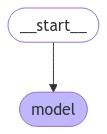

In [135]:
from IPython.display import Image
display(Image(app.get_graph().draw_mermaid_png()))

In [136]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "abc123"}}

query = "Hi! I'm at Google Dev Fest 2024. The crowd is dope."

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
pp.pprint(output["messages"][-1].pretty_print())

================================== Ai Message ==================================

That sounds amazing! Google Dev Fest events are always a great opportunity to meet fellow developers, learn about the latest technologies, and participate in hands-on workshops. What sessions or activities are you looking forward to the most?
None


In [137]:
query = "Where am I? I am fell lost."
input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
pp.pprint(output["messages"][-1].content)



('It sounds like you might be feeling a bit overwhelmed at the event! If '
 "you're feeling lost, here are a few tips to help you get your bearings:\n"
 '\n'
 '1. **Check the Event Schedule**: Look for a printed program or an app that '
 'lists the schedule of sessions, workshops, and keynotes. This can help you '
 'find your way to where you want to go.\n'
 '\n'
 '2. **Find Information Booths**: Most events have information or help desks '
 'where volunteers can assist you with directions and information about the '
 'event.\n'
 '\n'
 '3. **Look for Signage**: There are usually signs around the venue that '
 'indicate where different sessions are taking place or where amenities like '
 'restrooms and food are located.\n'
 '\n'
 '4. **Network with Others**: Don’t hesitate to ask fellow attendees for help '
 'or guidance. They might be able to point you in the right direction or even '
 'join you for the next session.\n'
 '\n'
 "5. **Take a Break**: If you're feeling really overwhelmed,

In [138]:
from langchain_core.messages import AIMessage

for chunk, metadata in app.stream(
    {"messages": input_messages},
    config,
    stream_mode="messages",
):
    if isinstance(chunk, AIMessage):  # Filter to just model responses
        print(chunk.content, end="|")

|It| sounds| like| you| might| be| feeling| a| bit| overwhelmed| at| the| event|!| If| you're| feeling| lost|,| here| are| a| few| tips| to| help| you| get| your| bearings|:

|1|.| **|Check| the| Event| Schedule|**|:| Look| for| a| printed| program| or| an| app| that| lists| the| schedule| of| sessions|,| workshops|,| and| key|notes|.| This| can| help| you| find| your| way| to| where| you| want| to| go|.

|2|.| **|Find| Information| Booth|s|**|:| Most| events| have| information| or| help| desks| where| volunteers| can| assist| you| with| directions| and| information| about| the| event|.

|3|.| **|Look| for| Sign|age|**|:| There| are| usually| signs| around| the| venue| that| indicate| where| different| sessions| are| taking| place| or| where| amenities| like| rest|rooms| and| food| are| located|.

|4|.| **|Network| with| Others|**|:| Don|’t| hesitate| to| ask| fellow| attendees| for| help| or| guidance|.| They| might| be| able| to| point| you| in| the| right| direction| or| even| join|

# LLM Tool Calling and ReAct Agent

In [139]:
from langchain_community.tools import TavilySearchResults
from typing import List, Tuple
from typing_extensions import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langgraph.prebuilt import InjectedState
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper


api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=100)

In [140]:
search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

In [141]:
@tool
def get_context(question: str, state: Annotated[dict, InjectedState]):
    """Get relevant context for answering the question."""
    return "\n\n".join(doc for doc in state["docs"])

In [142]:
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."

In [143]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode, create_react_agent
from langgraph.checkpoint.memory import MemorySaver

In [144]:
tools = [search_tool, wiki_tool, get_context, get_weather]

In [145]:
from typing import List
from langgraph.prebuilt.chat_agent_executor import AgentState
from langchain_core.documents import Document


class State(AgentState):
    docs: List[str]

In [146]:
tool_node = ToolNode(tools)
checkpointer = MemorySaver()
app = create_react_agent(
    model=o_llm, tools=tool_node, state_schema=State, checkpointer=checkpointer
)

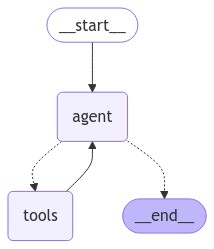

In [147]:
display(Image(app.get_graph().draw_mermaid_png()))

In [148]:
docs = [
    "FooBar company just raised 1 Billion dollars!",
    "FooBar company was founded in 2019",
]

inputs = {
    "messages": [{"type": "user", "content": "what's the latest news about Google Dev Fest 2024"}],
    "docs": docs,
}
config = {"configurable": {"thread_id": "1"}}
for chunk in app.stream(inputs, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the latest news about Google Dev Fest 2024
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_MdrQksake6vIMfDWV52mvKyQ)
 Call ID: call_MdrQksake6vIMfDWV52mvKyQ
  Args:
    query: Google Dev Fest 2024 news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://gdg.community.dev/events/details/google-gdg-malmo-presents-devfest-2024/", "content": "DevFest 2024. Stora Varvsgatan 6A, 6A Stora Varvsgatan, Malmö, 211 19. GDG Malmö. DevFest 2024 is a global community-led tech conference hosted by Google Developer Groups, focusing on the latest in technology, software development, and innovation."}, {"url": "https://gdg.community.dev/events/details/google-gdg-zagreb-presents-devfest-2024/", "content": "DevFest 2024. 🎉 DevFest 2024 is just around the corne

In [149]:
inputs = {
    "messages": [
        {"type": "user", "content": "Tell me Sundar Pichai Wiki page"}
    ],
    "docs": docs,
}
config = {"configurable": {"thread_id": "1"}}
for chunk in app.stream(inputs, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Tell me Sundar Pichai Wiki page
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_zzbemuWQVCcWD3uMj2s6AFBA)
 Call ID: call_zzbemuWQVCcWD3uMj2s6AFBA
  Args:
    query: Sundar Pichai
================================= Tool Message =================================
Name: wikipedia

Page: Sundar Pichai
Summary: Pichai Sundararajan (born June 10, 1972), better known as Sundar Pichai
================================== Ai Message ==================================

Sundar Pichai, born on June 10, 1972, is an Indian-American business executive best known as the CEO of Alphabet Inc. and its subsidiary Google LLC. He originally joined Google in 2004, where he initially worked on Google Toolbar and later led the development of Google Chrome, which became one of the most popular web browsers globally.

Pichai's leadership style emphasizes collaboration and i

In [150]:
inputs = {
    "messages": [{"type": "user", "content": "Tell me Todays weather in San Francisco"}],
    "docs": docs,
}
config = {"configurable": {"thread_id": "1"}}
for chunk in app.stream(inputs, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Tell me Todays weather in San Francisco
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_89DpdjmUPTjWwUWQPtCpYweK)
 Call ID: call_89DpdjmUPTjWwUWQPtCpYweK
  Args:
    location: San Francisco
================================= Tool Message =================================
Name: get_weather

It's 60 degrees and foggy.
================================== Ai Message ==================================

Today's weather in San Francisco is 60 degrees Fahrenheit and foggy.


# LLM Structured Outputs from documents

In [151]:
# Extracted from Web scraping
g_dev_fest_web = """
DevFest Mississauga x GDG Sheridan DevFest 2024

Location: Sheridan College Square One, 4180 Duke of York Boulevard, Mississauga, L5B 3W3
Date & Time: Saturday, November 2, 2024, 9:00 AM – 5:00 PM (EDT)
Organizers:
Ash Srivastava - Organizer (Red Pico)
Rucha Acharya - Co-Organizer
John Quien - Co-Organizer
Event Overview
Join GDG Mississauga for DevFest 2024! Dive into exciting sessions featuring industry leaders who will share their insights and experiences, sparking your passion for technology. Whether you’re a seasoned developer or just starting your journey, this event has something for everyone.

Key Themes
AI - Harness the power of Artificial Intelligence in modern applications.
Build with AI - Practical workshops to build AI-powered solutions.
Career Development - Sessions focused on advancing your career in tech.
Networking - Opportunities to connect with professionals and like-minded innovators.
Event Highlights
🚀 Hands-On Workshops: Participate in workshops to build your own projects using cutting-edge AI tools. This is an opportunity to turn ideas into reality!
🌐 Networking Opportunities: Connect with fellow tech enthusiasts, seasoned professionals, and innovators. Expand your network for potential collaborations.
🔥 Inspirational Talks: Hear from influential speakers who are shaping the future of tech. Get motivated and equipped with the knowledge you need to thrive in this ever-evolving industry.
Key Sessions (from Agenda)
Registration: 9:00 AM - 10:00 AM
Welcome and Agenda Overview: 10:00 AM - 10:10 AM by John Quien, Rucha Acharya, Connor Uhrig
Keynote: 10:10 AM - 10:20 AM by Ash Srivastava
Supercharge Your AI - Build RAG Solutions with AI: 10:20 AM - 11:45 AM by Faisal Abid
Lunch/Networking: 11:50 AM - 12:50 PM
Power of Mentorship - CoMunity Canada: 1:00 PM - 1:30 PM by Sachin Kodate, Siddhesh Thakur
Women Leaders in Tech Panel: 1:30 PM - 2:20 PM with Frincy Clement, Valeria Ponis, Lavanya Natarajan
Building Scalable AI Agents for Content Creation: 2:30 PM - 3:30 PM by Akash Shetty
Use No Code AI Tools to Create SaaS Applications: 3:45 PM - 4:00 PM by Abhijit Temkar
Networking and Job Searching in Tech: 4:00 PM - 4:30 PM by Samiha Nusrat, Tenille Chisholm
Raffle Prizes and Closing: 4:30 PM - 4:45 PM
Social Media & Contact
Social Media Links:

Facebook, Twitter, LinkedIn sharing options available.
Contact Information: For inquiries, you can reach out to the organizing team via the contact form on the website.

#DevFest2024 #GDGMississauga #TechInnovation

Quick Links:

About GDG
Chapters
Upcoming Events
Privacy Policy
Terms
Note: The event is sold out with 349 RSVPs.
"""

In [152]:
from typing import List, Optional
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate


class Organizer(BaseModel):
    name: str = Field(description="Name of the organizer.")
    role: str = Field(description="Role of the organizer.")
    affiliation: Optional[str] = Field(
        description="Affiliation of the organizer, if available."
    )


class Session(BaseModel):
    title: str = Field(description="Title of the session.")
    time: str = Field(description="Timeslot for the session.")
    speakers: List[str] = Field(description="Speakers of the session.")


class DevFestEvent(BaseModel):
    title: str = Field(description="Event title.")
    location: str = Field(description="Location of the event.")
    date_time: str = Field(description="Date and time of the event.")
    organizers: List[Organizer] = Field(description="List of organizers.")
    overview: str = Field(description="Overview of the event.")
    key_themes: List[str] = Field(description="Key themes of the event.")
    highlights: List[str] = Field(description="Highlights of the event.")
    sessions: List[Session] = Field(description="Sessions in the event.")
    social_media_links: List[str] = Field(description="Social media sharing options.")
    contact_info: str = Field(description="Contact information for the event.")
    quick_links: List[str] = Field(description="Quick links related to the event.")
    note: Optional[str] = Field(description="Additional notes about the event.")


devfest_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Extract and structure the information about the event as per the DevFestEvent schema.
            Parse the details for event title, location, date and time, organizers, event overview, key themes, highlights,
            sessions, social media links, contact information, quick links, and any additional notes.""",
        ),
        ("user", "{event_text}"),
    ]
)

devfest_event_extraction = devfest_prompt_template | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(DevFestEvent)

In [153]:
response = devfest_event_extraction.invoke({"event_text": g_dev_fest_web})

In [154]:
import json
json.loads(response.json())

{'title': 'DevFest Mississauga x GDG Sheridan DevFest 2024',
 'location': 'Sheridan College Square One, 4180 Duke of York Boulevard, Mississauga, L5B 3W3',
 'date_time': 'Saturday, November 2, 2024, 9:00 AM – 5:00 PM (EDT)',
 'organizers': [{'name': 'Ash Srivastava',
   'role': 'Organizer',
   'affiliation': 'Red Pico'},
  {'name': 'Rucha Acharya', 'role': 'Co-Organizer', 'affiliation': None},
  {'name': 'John Quien', 'role': 'Co-Organizer', 'affiliation': None}],
 'overview': 'Join GDG Mississauga for DevFest 2024! Dive into exciting sessions featuring industry leaders who will share their insights and experiences, sparking your passion for technology. Whether you’re a seasoned developer or just starting your journey, this event has something for everyone.',
 'key_themes': ['AI - Harness the power of Artificial Intelligence in modern applications.',
  'Build with AI - Practical workshops to build AI-powered solutions.',
  'Career Development - Sessions focused on advancing your career

### Collaboration Multi Agent

In [49]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [50]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = (
        f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    )
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

<>:25: SyntaxWarning: invalid escape sequence '\`'
<>:25: SyntaxWarning: invalid escape sequence '\`'
<>:25: SyntaxWarning: invalid escape sequence '\`'
<>:25: SyntaxWarning: invalid escape sequence '\`'
/var/folders/xr/_lgq_d2n0gqcb9j65glnlwjc0000gn/T/ipykernel_54511/3679402323.py:25: SyntaxWarning: invalid escape sequence '\`'
  f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
/var/folders/xr/_lgq_d2n0gqcb9j65glnlwjc0000gn/T/ipykernel_54511/3679402323.py:25: SyntaxWarning: invalid escape sequence '\`'
  f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [51]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [61]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4o-mini")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="When requested to generate a chart, you should generate a chart and display it. Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

In [62]:
# Define the tool node
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [63]:
# Either agent can decide to end
from typing import Literal


def router(state):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        return END
    return "continue"

In [64]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", END: END},
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

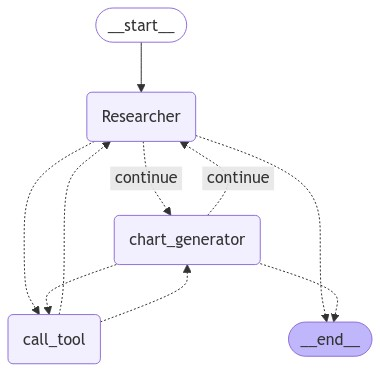

In [65]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GnO7Vd27oH9Fz8OB7RK38ObE', 'function': {'arguments': '{"query":"Canada GDP data past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 215, 'total_tokens': 239, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bfc6a7dc2', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-ec54a361-3536-48d1-ae13-1e625cd032f4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Canada GDP data past 5 years'}, 'id': 'call_GnO7Vd27oH9Fz8OB7RK38ObE', 'type': 'tool_call'}], usage_metadata={'input_tokens': 215, 'output_tokens': 24, 'total_tokens': 239, 'input_token_details': {'cache_read':

Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sX3YbRH2PyT7VdNXfSwjHb6L', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# GDP data for Canada over the past 5 years\\nyears = [2019, 2020, 2021, 2022, 2023]\\ngdp_values = [1743.73, 1655.68, 2007.47, 2161.48, 2140.09]  # in billion USD\\n\\n# Create a line chart\\nplt.figure(figsize=(10, 6))\\nplt.plot(years, gdp_values, marker=\'o\')\\nplt.title(\'Canada GDP Over the Past 5 Years\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP (in billion USD)\')\\nplt.xticks(years)\\nplt.grid(True)\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 177, 'prompt_tokens': 5069, 'total_tokens': 5246, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fi

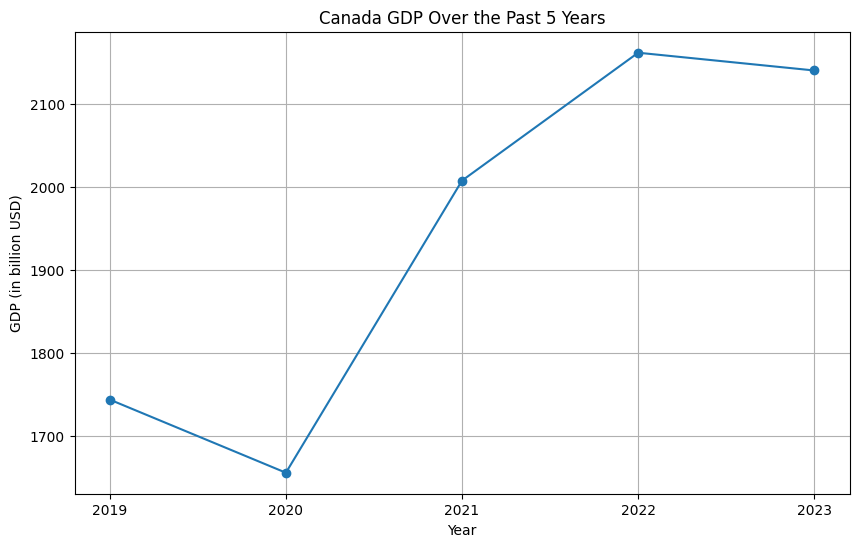

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n\\`\\`\\`python\nimport matplotlib.pyplot as plt\n\n# GDP data for Canada over the past 5 years\nyears = [2019, 2020, 2021, 2022, 2023]\ngdp_values = [1743.73, 1655.68, 2007.47, 2161.48, 2140.09]  # in billion USD\n\n# Create a line chart\nplt.figure(figsize=(10, 6))\nplt.plot(years, gdp_values, marker='o')\nplt.title('Canada GDP Over the Past 5 Years')\nplt.xlabel('Year')\nplt.ylabel('GDP (in billion USD)')\nplt.xticks(years)\nplt.grid(True)\nplt.show()\n\\`\\`\\`\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='call_sX3YbRH2PyT7VdNXfSwjHb6L')]}}
----
{'chart_generator': {'messages': [AIMessage(content="FINAL ANSWER: Here is the chart showing Canada's GDP over the past five years:\n\n![Canada GDP Over the Past 5 Years](attachment://Canada_GDP_Chart.png)\n\nIf you have any further requests or need additional information, feel free to ask!", additional_kwa

In [69]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="""Fetch the Canada's GDP over the past 5 years
                and then create a chart for me using the chart_generator tool."""
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

# Supervisor Multi Agent

In [70]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

In [71]:
from langchain_core.messages import HumanMessage


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

In [73]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members


class routeResponse(BaseModel):
    next: Literal[*options]


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


llm = ChatOpenAI(model="gpt-4o-mini")


def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

In [75]:
import functools
import operator
from typing import Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

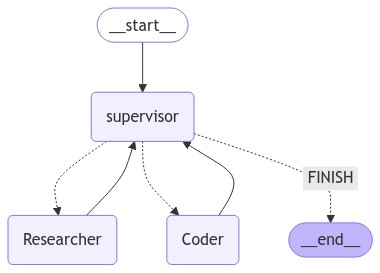

In [76]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [78]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a brief research report on Google Dev Fest 2024. And add code to make it more interesting")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='### Research Report on Google Dev Fest 2024\n\n**Overview:**\nGoogle Dev Fest 2024 is an annual international festival organized by Google Developer Groups (GDGs) worldwide. The event aims to bring together students, developers, and tech enthusiasts for a day filled with learning, networking, and exploration of the latest trends in technology. Each local GDG tailors the event to meet the interests and needs of its community, making each Dev Fest unique.\n\n**Key Features:**\n- **Networking Opportunities:** Attendees can meet like-minded individuals, industry experts, and potential collaborators, fostering connections that may lead to future projects or job opportunities.\n- **Technical Talks and Workshops:** Various sessions ranging from beginner to advanced topics are offered, ensuring that participants of all skill levels can benefit.\n- **Codelabs:** Hands-on coding sessions where particip

In [80]:
print("""### Research Report on Google Dev Fest 2024\n\n**Overview:**\nGoogle Dev Fest 2024 is an annual international festival organized by Google Developer Groups (GDGs) worldwide. The event aims to bring together students, developers, and tech enthusiasts for a day filled with learning, networking, and exploration of the latest trends in technology. Each local GDG tailors the event to meet the interests and needs of its community, making each Dev Fest unique.\n\n**Key Features:**\n- **Networking Opportunities:** Attendees can meet like-minded individuals, industry experts, and potential collaborators, fostering connections that may lead to future projects or job opportunities.\n- **Technical Talks and Workshops:** Various sessions ranging from beginner to advanced topics are offered, ensuring that participants of all skill levels can benefit.\n- **Codelabs:** Hands-on coding sessions where participants can work on real-world projects under the guidance of experienced developers.\n- **Diverse Topics:** Sessions typically cover a broad spectrum of technologies, including web development, machine learning, cloud computing, and mobile development, among others.\n\n**Event Details:**\n- **Date:** Various locations will host Dev Fest events throughout the latter part of 2024, with notable events including:\n  - GDG Nashik on November 24, 2024\n  - GDG Charlotte on December 13, 2024\n  - GDG New Delhi, which promises to be one of the largest developer gatherings of the year.\n\n**Conclusion:**\nGoogle Dev Fest 2024 represents a significant opportunity for developers to enhance their skills, engage with new technologies, and connect with a global community of tech enthusiasts. As the event approaches, participants are encouraged to check their local GDG chapters for specific event details and registration information.\n\n### Sample Code to Enhance Engagement\n\nTo make the report more interesting, we can include a simple interactive web application that lists upcoming Dev Fest events dynamically using JavaScript. Here’s a basic example:\n\n```html\n<!DOCTYPE html>\n<html lang="en">\n<head>\n    <meta charset="UTF-8">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0">\n    <title>Google Dev Fest 2024 Events</title>\n    <style>\n        body {\n            font-family: Arial, sans-serif;\n            background-color: #f4f4f4;\n            margin: 20px;\n        }\n        h1 {\n            color: #4285F4;\n        }\n        ul {\n            list-style-type: none;\n            padding: 0;\n        }\n        li {\n            background: #fff;\n            margin: 5px 0;\n            padding: 10px;\n            border-radius: 5px;\n            box-shadow: 0 2px 5px rgba(0,0,0,0.1);\n        }\n    </style>\n</head>\n<body>\n    <h1>Upcoming Google Dev Fest 2024 Events</h1>\n    <ul id="event-list"></ul>\n\n    <script>\n        const events = [\n            { name: "GDG Nashik", date: "November 24, 2024" },\n            { name: "GDG Charlotte", date: "December 13, 2024" },\n            { name: "GDG New Delhi", date: "TBD" }\n        ];\n\n        const eventList = document.getElementById(\'event-list\');\n        events.forEach(event => {\n            const li = document.createElement(\'li\');\n            li.textContent = `${event.name} - ${event.date}`;\n            eventList.appendChild(li);\n        });\n    </script>\n</body>\n</html>\n```\n\nThis code creates a simple web page that dynamically lists the upcoming Google Dev Fest events using JavaScript. Users can easily visualize the event information, making the report more engaging and interactive.""")

### Research Report on Google Dev Fest 2024

**Overview:**
Google Dev Fest 2024 is an annual international festival organized by Google Developer Groups (GDGs) worldwide. The event aims to bring together students, developers, and tech enthusiasts for a day filled with learning, networking, and exploration of the latest trends in technology. Each local GDG tailors the event to meet the interests and needs of its community, making each Dev Fest unique.

**Key Features:**
- **Networking Opportunities:** Attendees can meet like-minded individuals, industry experts, and potential collaborators, fostering connections that may lead to future projects or job opportunities.
- **Technical Talks and Workshops:** Various sessions ranging from beginner to advanced topics are offered, ensuring that participants of all skill levels can benefit.
- **Codelabs:** Hands-on coding sessions where participants can work on real-world projects under the guidance of experienced developers.
- **Diverse Topics:*

# Hierarchical Multi Agent

In [100]:

from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

In [101]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"

<>:91: SyntaxWarning: invalid escape sequence '\`'
<>:91: SyntaxWarning: invalid escape sequence '\`'
<>:91: SyntaxWarning: invalid escape sequence '\`'
<>:91: SyntaxWarning: invalid escape sequence '\`'
/var/folders/xr/_lgq_d2n0gqcb9j65glnlwjc0000gn/T/ipykernel_54511/4261612481.py:91: SyntaxWarning: invalid escape sequence '\`'
  return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
/var/folders/xr/_lgq_d2n0gqcb9j65glnlwjc0000gn/T/ipykernel_54511/4261612481.py:91: SyntaxWarning: invalid escape sequence '\`'
  return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [102]:
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage, trim_messages

llm = ChatOpenAI(model="gpt-4o-mini")

trimmer = trim_messages(
    max_tokens=100000,
    strategy="last",
    token_counter=llm,
    include_system=True,
)


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | trimmer
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [103]:
import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str


llm = ChatOpenAI(model="gpt-4o-mini")

search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

research_agent = create_react_agent(llm, tools=[scrape_webpages])
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper"],
)

In [104]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
)


research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()

def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain

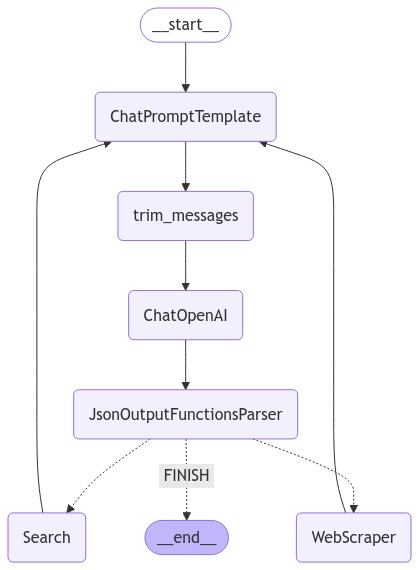

In [105]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [106]:
for s in research_chain.stream(
    "Tell me about the Toronto gold heist",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Search'}}
---
{'Search': {'messages': [HumanMessage(content='The Toronto gold heist refers to a significant theft that took place on April 17, 2023, at Toronto Pearson International Airport, where over C$20 million (approximately US$15 million) worth of gold and cash was stolen. The incident involved the theft of 6,600 gold bars, making it one of the largest gold heists in Canadian history.\n\n### Details of the Heist:\n- **Method**: The gold was offloaded from an inbound aircraft and transferred to an Air Canada holding facility. The thieves used a forged shipping document to deceive Air Canada staff into loading the gold onto a getaway truck.\n- **Investigation**: The police began investigating the incident, and it was revealed that some of the suspects had connections to firearms trafficking.\n- **Outcome**: Reports indicated that much of the stolen gold has since been traced overseas, with destinations including Dubai and India.\n\nFor further reading, you 

In [107]:
import operator
from pathlib import Path


# Document writing team graph state
class DocWritingState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This tracks the shared directory state
    current_files: str


# This will be run before each worker agent begins work
# It makes it so they are more aware of the current state
# of the working directory.
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


llm = ChatOpenAI(model="gpt-4o-mini")

doc_writer_agent = create_react_agent(
    llm, tools=[write_document, edit_document, read_document]
)
# Injects current directory working state before each call
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_react_agent(llm, tools=[create_outline, read_document])
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

chart_generating_agent = create_react_agent(llm, tools=[read_document, python_repl])
context_aware_chart_generating_agent = prelude | chart_generating_agent
chart_generating_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="ChartGenerator"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

In [108]:
# Create the graph here:
# Note that we have unrolled the loop for the sake of this doc
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

# Add the edges that always occur
authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("ChartGenerator", "supervisor")

# Add the edges where routing applies
authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

authoring_graph.add_edge(START, "supervisor")
chain = authoring_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

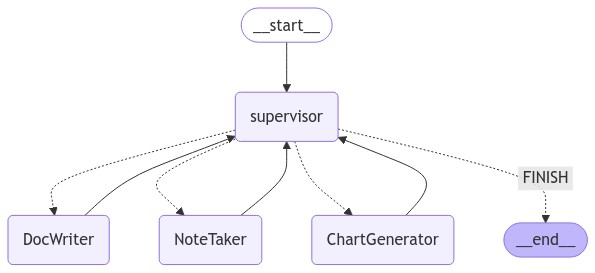

In [109]:
display(Image(chain.get_graph().draw_mermaid_png()))

In [110]:
for s in research_chain.stream(
    "Write a plot for a Netflix Documentary on the Toronto Gold Heist with each episode being 10 minutes long",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        pp.pprint(s)
        print("---")


{'supervisor': {'next': 'Search'}}
---
{'Search': {'messages': [HumanMessage(content='### Title: "The Toronto Gold Heist: A Daring Deception"\n\n#### Episode 1: "The Setup"\nIn this episode, viewers are introduced to the Toronto Gold Heist, exploring the background of the gold market and the significance of gold as a commodity. Experts discuss the security measures surrounding gold storage and introduce the key players involved in the heist. The episode ends with the heist\'s planning phase, highlighting the meticulous preparations made by the thieves.\n\n#### Episode 2: "Inside the Vault"\nThis episode delves into the specifics of the Toronto Gold Vault, examining its security features and the challenges it posed to potential thieves. Interviews with security experts reveal the vulnerabilities in the system and discuss how the heist was conceived. The episode includes dramatic reconstructions of the heist planning process and introduces the mastermind behind the operation.\n\n#### Epi

In [111]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PaperWritingTeam"],
)

In [112]:
# Top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str


def get_last_message(state: State) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}


# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "PaperWritingTeam", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("ResearchTeam", "supervisor")
super_graph.add_edge("PaperWritingTeam", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "PaperWritingTeam": "PaperWritingTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "supervisor")
super_graph = super_graph.compile()

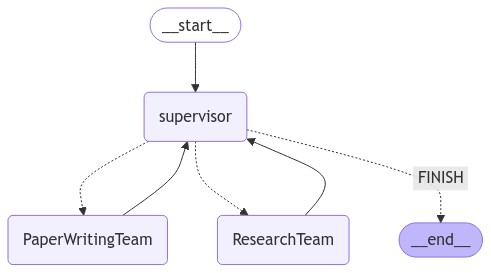

In [113]:
display(Image(super_graph.get_graph().draw_mermaid_png()))

In [115]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Write a plot for a Netflix Documentary on the Toronto Gold Heist with each episode being 10 minutes long"
            )
        ],
    },
    {"recursion_limit": 150},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'ResearchTeam'}}
---
{'ResearchTeam': {'messages': [HumanMessage(content='Here’s a refined plot for a Netflix documentary on the Toronto Gold Heist, structured into six 10-minute episodes, incorporating insights into the heist and its implications:\n\n### Title: "The Toronto Gold Heist: A Daring Deception"\n\n**Episode 1: The Setup**\nThe series kicks off with a gripping overview of the Toronto Gold Heist, detailing its historical significance as one of Canada\'s largest gold thefts. Viewers are introduced to the key players: the mastermind behind the heist, the thieves, and the Royal Canadian Mint\'s security team. Expert interviews and archival footage shed light on the Mint\'s operations and the immense value of the gold. The episode concludes with a tense atmosphere as it approaches the day before the heist, setting the stage for what’s to come.\n\n**Episode 2: The Heist Begins**\nIn a dramatic recounting, this episode covers the day of the heist. Through a 

In [116]:
print(
    """'Here’s a refined plot for a Netflix documentary on the Toronto Gold Heist, structured into six 10-minute episodes, incorporating insights into the heist and its implications:\n\n### Title: "The Toronto Gold Heist: A Daring Deception"\n\n**Episode 1: The Setup**\nThe series kicks off with a gripping overview of the Toronto Gold Heist, detailing its historical significance as one of Canada\'s largest gold thefts. Viewers are introduced to the key players: the mastermind behind the heist, the thieves, and the Royal Canadian Mint\'s security team. Expert interviews and archival footage shed light on the Mint\'s operations and the immense value of the gold. The episode concludes with a tense atmosphere as it approaches the day before the heist, setting the stage for what’s to come.\n\n**Episode 2: The Heist Begins**\nIn a dramatic recounting, this episode covers the day of the heist. Through a blend of reenactments and real eyewitness accounts, the meticulous execution of the thieves’ plan is revealed. They utilize insider knowledge, disguises, and advanced technology to bypass security measures at the Mint. The episode builds suspense as the thieves make their escape, leaving viewers eagerly anticipating the aftermath.\n\n**Episode 3: The Investigation**\nThe focus shifts to the aftermath of the heist and the subsequent investigation led by the Toronto Police Service. This episode highlights the significant challenges investigators face, such as the scarcity of physical evidence and the complexities involved in tracking stolen gold. Interviews with detectives and forensic experts provide an inside look into their investigative techniques. The episode culminates in a breakthrough, teasing the potential identity of the culprits.\n\n**Episode 4: The Aftermath**\nExploring the immediate consequences of the heist, this episode discusses the Royal Canadian Mint\'s response, insurance claims, and the media frenzy that ensued. Financial experts analyze the gold market’s fluctuations post-heist. Insights into the lives of the thieves following the heist reveal how they either evaded capture or faced dire consequences, maintaining the tension of their fate.\n\n**Episode 5: Unraveling the Truth**\nAs the investigation deepens, this episode highlights the unraveling of the thieves\' network. It showcases the collaboration between Canadian and international law enforcement, using advanced tracking technologies to trace the stolen gold. New figures emerge, including informants and rival criminals. The narrative takes unexpected twists, leading to a dramatic revelation about the thieves’ whereabouts.\n\n**Episode 6: The Final Showdown**\nThe finale builds to a thrilling conclusion with the confrontation between law enforcement and the thieves. Viewers witness the dramatic arrests and the crucial evidence that led to their capture. Insights from detectives involved in the case provide a personal touch to the resolution. The documentary wraps up with reflections on the heist’s legacy, discussing its impact on security protocols in financial institutions and the broader implications for crime and justice.\n\n**Epilogue: Gold\'s Value**\nIn a brief reflective segment, the documentary revisits the allure of gold in society, contemplating the lengths individuals will go to obtain it. This ties back to the heist, leaving audiences with thought-provoking questions about greed and its consequences, ensuring the narrative resonates even after the credits roll.'
      """
)

'Here’s a refined plot for a Netflix documentary on the Toronto Gold Heist, structured into six 10-minute episodes, incorporating insights into the heist and its implications:

### Title: "The Toronto Gold Heist: A Daring Deception"

**Episode 1: The Setup**
The series kicks off with a gripping overview of the Toronto Gold Heist, detailing its historical significance as one of Canada's largest gold thefts. Viewers are introduced to the key players: the mastermind behind the heist, the thieves, and the Royal Canadian Mint's security team. Expert interviews and archival footage shed light on the Mint's operations and the immense value of the gold. The episode concludes with a tense atmosphere as it approaches the day before the heist, setting the stage for what’s to come.

**Episode 2: The Heist Begins**
In a dramatic recounting, this episode covers the day of the heist. Through a blend of reenactments and real eyewitness accounts, the meticulous execution of the thieves’ plan is reveale

# Planning Agent

In [121]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
prompt = hub.pull("ih/ih-react-agent-executor")
prompt.pretty_print()

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o-mini")
agent_executor = create_react_agent(llm, tools, state_modifier=prompt)

================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{messages}


In [122]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [123]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [127]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(Plan)

In [125]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

In [126]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [129]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    should_end,
    ["agent", END],
)

app = workflow.compile()

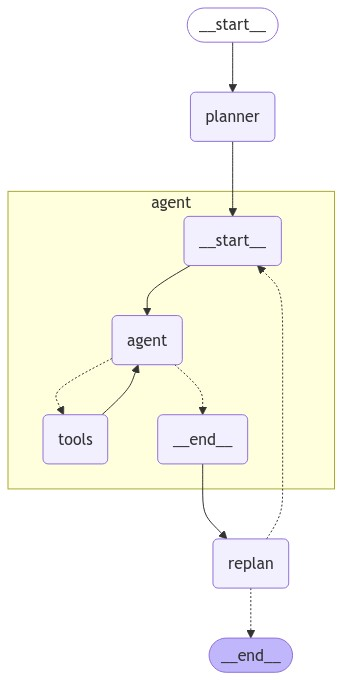

In [130]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [131]:
config = {"recursion_limit": 150}
inputs = {
    "input": "Write a plot for a Netflix Documentary on the Toronto Gold Heist with each episode being 10 minutes long?"
}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Episode 1: Introduction to the Toronto Gold Heist - Overview of the heist, its significance, and the players involved. Introduce the location, the Toronto International Gold Exchange, and the context of gold trading in Canada.', 'Episode 2: The Planning Phase - Explore how the heist was meticulously planned, including interviews with experts on heist strategies and insights into the criminal mind.', 'Episode 3: The Execution - A detailed account of the day of the heist, including the methods used by the thieves, the security measures in place, and how they were circumvented.', 'Episode 4: The Aftermath - Discuss the immediate consequences of the heist, including the response from law enforcement and the impact on the gold market.', 'Episode 5: The Investigation - Follow the investigation process, highlighting key leads, suspects, and the challenges faced by the police in solving the case.', 'Episode 6: Theories and Speculations - Present various theories about the heist, inc